In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner

In [2]:
#read in data
df = pd.read_csv('1_ZFBS_tuning_AA_homodimer.csv',header=None)
df = df.rename(columns={0: '∆G', 1: 'FR-coop', 2: 'FRc err', 3: 'FR-non-coop', 4: 'FRnc err'})

#sort data - lowest to highest ∆G
a = np.array(df['∆G'])
b = np.array(df['FR-coop'])
c = np.array(df['FRc err'])
d = np.array(df['FR-non-coop'])
e = np.array(df['FRnc err'])

abcde = np.column_stack((a, b, c, d, e))

col = 0
data = abcde[np.argsort(abcde[:, col])]

dG = data[:, 0]
FR_c = data[:, 1]
FRerr_c = data[:, 2]
FR_n = data[:, 3]
FRerr_n = data[:, 4]

#Kd in nM
Kd = np.exp(dG/0.5921)*1e9

#add mutation type
dfv2 = pd.read_csv('1_ZFBS_tuning_AA_homodimer_err.csv', sep=',')

mutlabels = []
for i in range(22):
    mutlabels.append('1 bp')

for i in range(8):
    mutlabels.append('2 bp')

mutlabels.append('wild type')

dfv2['mutation type'] = mutlabels

# 1 bp 
ind_1 = dfv2['mutation type'] == '1 bp'
df_1bp = dfv2.loc[ind_1, :]
Kd_1 = np.array(df_1bp['Kd'])
Kderr_1 = np.array(df_1bp['Kd err'])
FR_1 = np.array(df_1bp['FR-coop'])
FRerr_1 = np.array(df_1bp['FRc err'])

# 2 bp 
ind_2 = dfv2['mutation type'] == '2 bp'
df_2bp = dfv2.loc[ind_2, :]
Kd_2 = np.array(df_2bp['Kd'])
Kderr_2 = np.array(df_2bp['Kd err'])
FR_2 = np.array(df_2bp['FR-coop'])
FRerr_2 = np.array(df_2bp['FRc err'])

# wild type 
ind_wt = dfv2['mutation type'] == 'wild type'
df_wt = dfv2.loc[ind_wt, :]
Kd_wt = np.array(df_wt['Kd'])
Kderr_wt = np.array(df_wt['Kd err'])
FR_wt = np.array(df_wt['FR-coop'])
FRerr_wt = np.array(df_wt['FRc err'])

# 1 bp 
FR_1nc = np.array(df_1bp['FR-non-coop'])
FRerr_1nc = np.array(df_1bp['FRnc err'])

# 2 bp 
FR_2nc = np.array(df_2bp['FR-non-coop'])
FRerr_2nc = np.array(df_2bp['FRnc err'])

# wild type 
FR_wtnc = np.array(df_wt['FR-non-coop'])
FRerr_wtnc = np.array(df_wt['FRnc err'])


In [3]:
def FR_double(C0, C1, Erp, Er, x):
    """Model for fold repression for a homodimer --> AA leucine zipper --> coop"""
    UR = 1 / (1 + C0)
    Freg1 = 1 + (C1/x)*np.exp(-Erp) + (C1/(x**2))*np.exp(-Erp)*np.exp(-Er)
    Freg2 = 1 + C1/x + C1/(x**2)*np.exp(-Er)
    Freg = Freg1 / Freg2
    R = 1/(1 + C0/Freg)
    return UR/R

In [4]:
def FR_double_nc(C0, C1, Erp, x):
    """Model for fold repression for a homodimer --> AA leucine zipper --> non-coop"""
    UR = 1 / (1 + C0)
    Freg1 = 1 + (C1/x)*np.exp(-Erp) + (C1/(x**2))*np.exp(-Erp)
    Freg2 = 1 + C1/x + C1/(x**2)
    Freg = Freg1 / Freg2
    R = 1/(1 + C0/Freg)
    return UR/R

In [5]:
#cooperative
def lnlike(theta, x, y, yerr):
    """calculate log likelihood"""
    C0, C1, Erp, Er = theta
    
    ypred = FR_double(C0, C1, Erp, Er, x)
    
    inv_sigma2 = 1/(yerr**2)
    X1 = np.sum((ypred-y)**2 * inv_sigma2 - np.log(inv_sigma2))
    return -0.5 * X1

def lnprior(theta, y, yerr):
    """calculate log priors"""
    C0, C1, Erp, Er = theta
    if not (0 < C0 and 0 < C1 and 0 < Erp): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 3e-3
    sigma1 = 3e-2
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 1e2
    sigma2 = 1e1
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 10
    sigma3 = 1
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(Erp - mu3)**2/sigma3**2
    
    mu4 = -4
    sigma4 = 1
    log_Pr4 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma4)) - 0.5*(Er - mu4)**2/sigma4**2
    
    return log_Pr1 + log_Pr2 + log_Pr3 + log_Pr4

def lnprob(theta, x, y, yerr):
    """calculate log probability"""
    lp = lnprior(theta, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [10]:
#non-cooperative
def lnlike_nc(theta, x, y, yerr):
    """calculate log likelihood"""
    C0, C1, Erp = theta
    
    ypred = FR_double_nc(C0, C1, Erp, x)
    
    inv_sigma2 = 1/(yerr**2)
    X1 = np.sum((ypred-y)**2 * inv_sigma2 - np.log(inv_sigma2))
    return -0.5 * X1

def lnprior_nc(theta, y, yerr):
    """calculate log priors"""
    C0, C1, Erp = theta
    if not (0 < C0 and 0 < C1 and 0 < Erp): 
        return -np.inf # Hard-cutoff for positive value constraint

    mu1 = 5e-3
    sigma1 = 5e-3
    log_Pr1 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma1)) - 0.5*(C0 - mu1)**2/sigma1**2
    
    mu2 = 1e2
    sigma2 = 1e2
    log_Pr2 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma2)) - 0.5*(C1 - mu2)**2/sigma2**2
    
    mu3 = 1
    sigma3 = 5
    log_Pr3 = np.log(1.0 / (np.sqrt(2*np.pi)*sigma3)) - 0.5*(Erp - mu3)**2/sigma3**2
    
    return log_Pr1 + log_Pr2 + log_Pr3

def lnprob_nc(theta, x, y, yerr):
    """calculate log probability"""
    lp = lnprior_nc(theta, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_nc(theta, x, y, yerr)

In [6]:
# coop
ndim = 4
nwalkers = 50

pos = [np.array([3e-3*(1 + 1e-4*np.random.randn()),
                 1e2*(1 + 1e-4*np.random.randn()),
                 10*(1 + 1e-4*np.random.randn()),
                 -3*(1 + 1e-4*np.random.randn())
                ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(Kd, FR_c, FRerr_c), threads=4)


In [11]:
#non-coop
ndim = 3
nwalkers = 50

pos = [np.array([5e-3*(1 + 1e-4*np.random.randn()),
                 2e2*(1 + 1e-4*np.random.randn()),
                 1*(1 + 1e-4*np.random.randn())
                 ]) for i in range(nwalkers)] # Initialise walkers 


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_nc, args=(Kd, FR_n, FRerr_n), threads=4)


In [12]:
print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(pos, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(pos, 10000)

Running burn-in...
Running production...


(array([[9.63063206e-03, 1.22658896e+02, 7.87575011e+00],
        [7.27721586e-03, 1.53739159e+02, 1.57722010e+01],
        [5.35147914e-03, 2.04876801e+02, 8.05590130e+00],
        [8.44527041e-03, 1.35134655e+02, 9.71356063e+00],
        [9.88666390e-03, 1.15720628e+02, 1.20078962e+01],
        [5.60018226e-03, 1.93117751e+02, 9.22610832e+00],
        [7.99682461e-03, 1.67146527e+02, 6.70151576e+00],
        [8.62052911e-03, 1.39669210e+02, 7.47893302e+00],
        [5.67809016e-03, 1.82455463e+02, 1.05908798e+01],
        [8.26411450e-03, 1.29769293e+02, 1.21785074e+01],
        [5.58039656e-03, 2.03675773e+02, 9.64881622e+00],
        [1.07733269e-02, 9.15299882e+01, 1.39253894e+01],
        [5.60269362e-03, 1.95024637e+02, 1.32110723e+01],
        [1.00021869e-02, 1.10877806e+02, 1.48386825e+01],
        [3.93728664e-03, 2.69725920e+02, 1.02313069e+01],
        [1.02963642e-02, 1.13492429e+02, 8.93937175e+00],
        [8.27031928e-03, 1.36772754e+02, 7.29356179e+00],
        [6.082

In [8]:
# coop.
samples1 = sampler.chain[:,:,:].reshape((-1,ndim))
samples1_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

In [13]:
# non-coop.
samples2 = sampler.chain[:,:,:].reshape((-1,ndim))
samples2_end = sampler.chain[:, 9000:, :].reshape((-1,ndim))

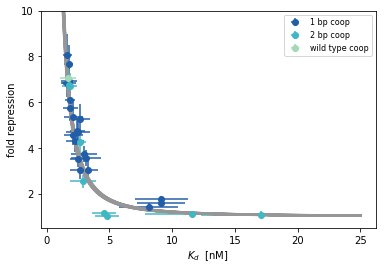

In [9]:
fig = plt.figure()

k = np.linspace(0.75, 25, 400)

for C0, C1, Erp, Er in samples1_end[np.random.randint(len(samples1_end), size=100)]:
    plt.plot(k, FR_double(C0, C1, Erp, Er, k), color='#969696', lw=2, alpha=0.7)

c1 = plt.errorbar(Kd_1, FR_1, xerr=Kderr_1, yerr=FRerr_1, 
             fmt='o', color='#225ea8', label='1 bp coop')
c2 = plt.errorbar(Kd_2, FR_2, xerr=Kderr_2, yerr=FRerr_2, 
             fmt='o', color='#41b6c4', label='2 bp coop')
wt = plt.errorbar(Kd_wt, FR_wt, xerr=Kderr_wt, yerr=FRerr_wt, 
             fmt='o', color='#a1dab4', label='wild type coop')

plt.ylim(0.5, 10)

plt.xlabel('$K_d$  [nM]')
plt.ylabel('$fold-repression$')

plt.legend(handles=[c1, c2, wt], fontsize=8)

plt.xlabel('$K_{d}$  [nM]')
plt.ylabel('fold repression')


plt.savefig('AA_coop_fit.pdf',dpi=150,transparent=True, bbox_inches='tight')

plt.show()

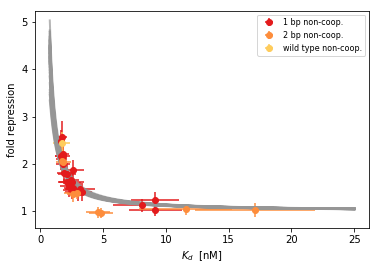

In [14]:
fig = plt.figure()

k = np.linspace(0.75, 25, 400)

for C0, C1, Erp in samples2_end[np.random.randint(len(samples2_end), size=100)]:
    plt.plot(k, FR_double_nc(C0, C1, Erp, k), color='#969696', lw=2, alpha=0.7)

n1 = plt.errorbar(Kd_1, FR_1nc, xerr=Kderr_1, yerr=FRerr_1nc, 
             fmt='o', color='#e31a1c', label='1 bp non-coop.')
n2 = plt.errorbar(Kd_2, FR_2nc, xerr=Kderr_2, yerr=FRerr_2nc, 
             fmt='o', color='#fd8d3c', label='2 bp non-coop.')
wtn = plt.errorbar(Kd_wt, FR_wtnc, xerr=Kderr_wt, yerr=FRerr_wtnc, 
             fmt='o', color='#fecc5c', label='wild type non-coop.')

#plt.ylim(0.5, 10)

plt.xlabel('$K_d$  [nM]')
plt.ylabel('$fold-repression$')

plt.legend(handles=[n1, n2, wtn], fontsize=8)

plt.xlabel('$K_{d}$  [nM]')
plt.ylabel('fold repression')


plt.savefig('AA_noncoop_fit.pdf',dpi=150,transparent=True, bbox_inches='tight')

plt.show()

Quantiles:
[(0.16, 0.0017339453063552515), (0.5, 0.0028940484671280326), (0.84, 0.004571074731111212)]
Quantiles:
[(0.16, 87.4110991910865), (0.5, 97.44821552209642), (0.84, 107.380308202509)]
Quantiles:
[(0.16, 10.558347038572537), (0.5, 11.241355023280683), (0.84, 11.976071666643136)]
Quantiles:
[(0.16, -4.616524144194655), (0.5, -4.090958845126694), (0.84, -3.614939477847873)]


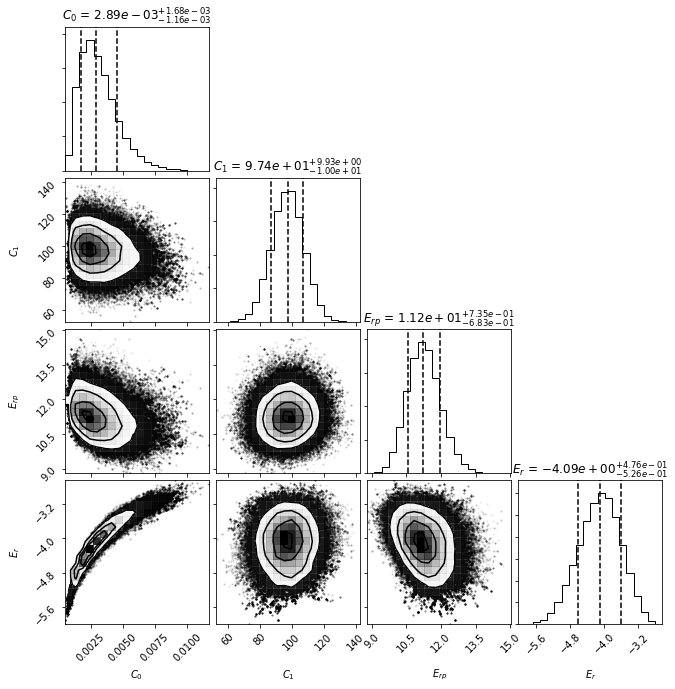

In [15]:
df = pd.DataFrame(samples1)
df.to_csv(path_or_buf='samplesout_AA_coop.csv', sep=',')

df1 = pd.read_csv('samplesout_AA_coop.csv', delimiter=',')

iterations = 10000
tburn = 1000

data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)), (df1.shape[1]-1))


for i in range(0, int(df1.shape[1]-1)):
    for j in range(1, nwalkers+1):
        data2[(iterations - tburn)*(j - 1):(iterations - tburn)*(j),i]=np.array(df1.iloc[iterations*j - iterations + tburn: iterations*j, i + 1])
        
parameternames = ["$C_0$", "$C_1$", "$E_{rp}$", "$E_r$"]

fig = corner.corner(data2, 
                    labels=parameternames, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, 
                    title_fmt='.2e', 
                    title_kwargs={"fontsize": 12},
                    verbose=True)

plt.savefig('AA_coop_corner.pdf',dpi=150,transparent=True, bbox_inches='tight')
plt.show()

Quantiles:
[(0.16, 0.005465766681829756), (0.5, 0.007914364355318698), (0.84, 0.011296886703774923)]
Quantiles:
[(0.16, 99.62301225796567), (0.5, 142.17264271874842), (0.84, 205.20028410841005)]
Quantiles:
[(0.16, 8.144700878401032), (0.5, 9.826743017177655), (0.84, 12.327145825357817)]


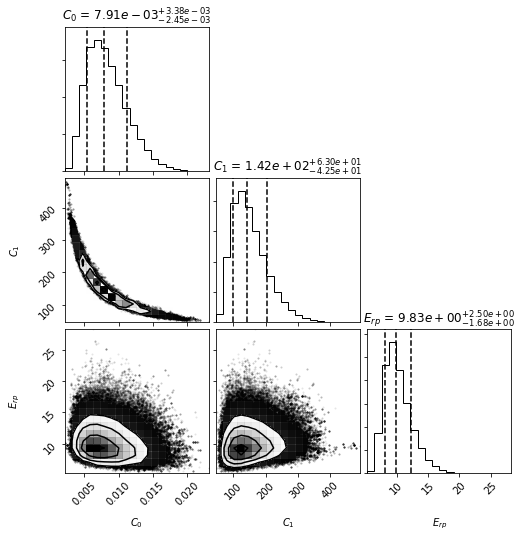

In [16]:
df = pd.DataFrame(samples2)
df.to_csv(path_or_buf='samplesout_AA_noncoop.csv', sep=',')

df1 = pd.read_csv('samplesout_AA_noncoop.csv', delimiter=',')

iterations = 10000
tburn = 500

data2 = np.zeros((df1.shape[0]-tburn*nwalkers)*(df1.shape[1]-1)).reshape((df1.shape[0]-(tburn*nwalkers)), (df1.shape[1]-1))


for i in range(0, int(df1.shape[1]-1)):
    for j in range(1, nwalkers+1):
        data2[(iterations - tburn)*(j - 1):(iterations - tburn)*(j),i]=np.array(df1.iloc[iterations*j - iterations + tburn: iterations*j, i + 1])
        
parameternames = ["$C_0$", "$C_1$", "$E_{rp}$"]

fig = corner.corner(data2, 
                    labels=parameternames, 
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, 
                    title_fmt='.2e', 
                    title_kwargs={"fontsize": 12},
                    verbose=True)

plt.savefig('AA_noncoop_corner.pdf',dpi=150,transparent=True, bbox_inches='tight')
plt.show()

In [17]:
np.random.seed(0) # For reproducible outputs
modelscale1=np.linspace(1.5, 25, 400)
modelscale2=np.linspace(1, 25, 400)
numberofmodeltraces=10000

ypred1=np.zeros((len(modelscale1),numberofmodeltraces))
ypred2=np.zeros((len(modelscale2),numberofmodeltraces))

i=0
for C0, C1, Erp, Er in samples1[np.random.randint(len(samples1), size=numberofmodeltraces)]:
    ypred1[:, i] = FR_double(C0, C1, Erp, Er, modelscale1)
    i+=1

i=0
for C0, C1, Erp in samples2[np.random.randint(len(samples2), size=numberofmodeltraces)]:
    ypred2[:, i] = FR_double_nc(C0, C1, Erp, modelscale2)
    i+=1

# 2-sigma distributions
quant1=[np.mean(ypred1, axis=1)-2*np.std(ypred1, axis=1),
        np.mean(ypred1, axis=1),
        np.mean(ypred1, axis=1)+2*np.std(ypred1, axis=1)]

quant2=[np.mean(ypred2, axis=1)-2*np.std(ypred2, axis=1),
        np.mean(ypred2, axis=1),
        np.mean(ypred2, axis=1)+2*np.std(ypred2, axis=1)]


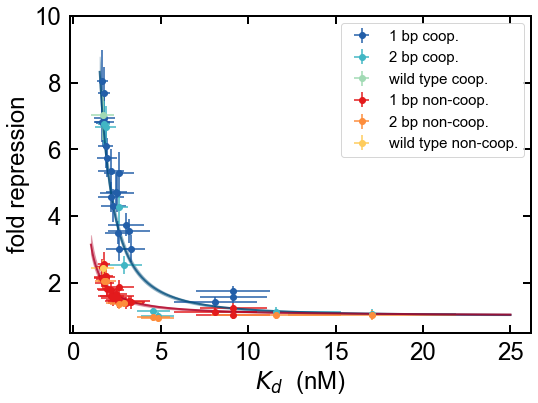

In [19]:
fig, ax = plt.subplots()


plt.fill_between(modelscale1, quant1[0], quant1[2], color='#034e7b', alpha=0.3)
plt.plot(modelscale1, quant1[1], '-', color='#034e7b', alpha=0.8, lw=2)

plt.fill_between(modelscale2, quant2[0], quant2[2], color='#b10026', alpha=0.3)
plt.plot(modelscale2, quant2[1], '-', color='#b10026', alpha=0.8, lw=2)

c1 = plt.errorbar(Kd_1, FR_1, xerr=Kderr_1, yerr=FRerr_1, 
             fmt='o', color='#225ea8', label='1 bp coop.')
c2 = plt.errorbar(Kd_2, FR_2, xerr=Kderr_2, yerr=FRerr_2, 
             fmt='o', color='#41b6c4', label='2 bp coop.')
wt = plt.errorbar(Kd_wt, FR_wt, xerr=Kderr_wt, yerr=FRerr_wt, 
             fmt='o', color='#a1dab4', label='wild type coop.')

n1 = plt.errorbar(Kd_1, FR_1nc, xerr=Kderr_1, yerr=FRerr_1nc, 
             fmt='o', color='#e31a1c', label='1 bp non-coop.')
n2 = plt.errorbar(Kd_2, FR_2nc, xerr=Kderr_2, yerr=FRerr_2nc, 
             fmt='o', color='#fd8d3c', label='2 bp non-coop.')
wtn = plt.errorbar(Kd_wt, FR_wtnc, xerr=Kderr_wt, yerr=FRerr_wtnc, 
             fmt='o', color='#fecc5c', label='wild type non-coop.')


plt.ylim(0.5, 10)

plt.xlabel('$K_d$  (nM)')
plt.ylabel('fold repression')

plt.legend(handles=[c1, c2, wt, n1, n2, wtn], fontsize=15)


ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2) 

ax.tick_params(which='major', width=2, length=8, pad=9,direction='in',top=True,right=True)
ax.tick_params(which='minor', width=2, length=4, pad=9,direction='in',top=True,right=True)

figure_options={'figsize':(8.27,5.83)} #figure size in inches. A4=11.7x8.3. A5=8.27,5.83
font_options={'size':'24','family':'sans-serif','sans-serif':'Arial'}
plt.rc('figure', **figure_options)
plt.rc('font', **font_options)

plt.savefig('AA_tuning_shaded.pdf',dpi=150,transparent=True, bbox_inches='tight')

plt.show()